##  <center>               *Pricing of VarSwaps Notebook* January 2023
##  <center>             Alexis Pauthonier--Delpeu


In [5]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt


## 1 Generating a Volatility Surface, a prerequisite to price VarSwaps

As Volatility surface is nevessary to price VarSwaps, but volatility modelling is not the purpose of this project, we generate the easiest possible volatility surface. For such purpose, we take a decreasing convex function that has a value of ATMVol when S=S0

\begin{align}
    \text{  Trivial volatility smile } \\[1em]
    f(S) = \frac{1}{S} \cdot S_0 * ATMVol 
\end{align}

In [6]:
# 1 Y Volatility Surface

def IV(spot, ATMVol, current_spot):
    return 1/(spot*100) * ATMVol * current_spot

In [7]:
#Params

ATMVol = 14
SX5E_spot = 4000
spot_array = np.arange(2000,6500,50)
strike_array = spot_array
strike_array_percent = strike_array/SX5E_spot
IV_array = IV(spot_array,ATMVol,SX5E_spot)
T = 1

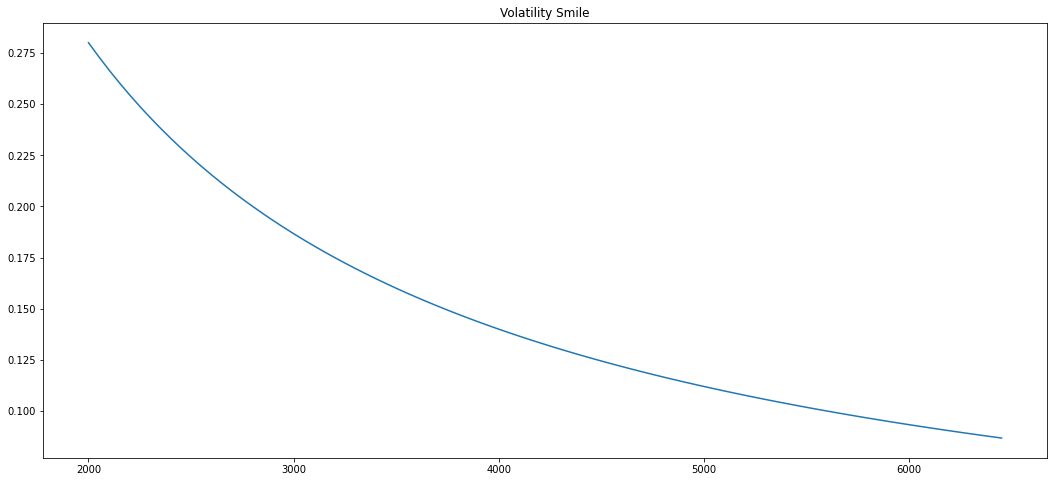

In [8]:
#Plot Volatility Surface
plt.figure(figsize=(18,8))
plt.plot(spot_array,IV_array)
plt.title("Volatility Smile")
plt.show()


# 2.1 VarSwap Payoff

\begin{align}
     VarianceSwapPayoff_T = \left[ RV - K_{var}^2\right] \cdot N_{var} \\[1em]
\end{align}

\begin{align}
    \text{where: } \\[1em]
    RV = \frac{252}{N_E} \cdot \sum_{t=1}^{N_A} \ln^2{(\frac{S_t}{S_{t-1}})}
\end{align}

\begin{align}
     N_E & \text{ is the number of estimated days in the period }
\end{align}

\begin{align}
     N_A & \text{ is the number of actual days in the period }
\end{align}

\begin{align}
    N_{var} & \text{ is the notionnal of the swap expressed in Var points}
\end{align}

# 2.2 VarSwap Pricing

The real advantage of using VarSwap as an instrument to trade volatility is that its pricing is model independant, as it can be replicated a static position in Calls and Puts can replicate the payoff.
This formula (Carr-Madan 2002) can be written  :

\begin{align}
     VarianceSwap_T = \frac{2}{T} \cdot \left[ r \cdot T -  \mathrm{ln}({\frac{F_T}{S_0}}) - (\frac{S_0}{F_T} \cdot \mathrm{e}^{r\cdot T} - 1) + \mathrm{e}^{r\cdot T} \cdot (\int_0^{F_T} Put(K,T) {\frac{\mathrm{d}K
}{K^2}} + \int_{F_T}^{\infty} Call(K,T) {\frac{\mathrm{d}K
}{K^2}} )\right]
\end{align}

Assuming r = 0, q = 0 and repo = 0 , we have : 

\begin{align}
     VarianceSwap_T = \frac{2}{T} \cdot \left[ \int_0^{S_0} Put(K,T) {\frac{\mathrm{d}K
}{K^2}} + \int_{S_0}^{\infty} Call(K,T) {\frac{\mathrm{d}K
}{K^2}} \right]
\end{align}

As Calls and Puts are traded for discretionary strikes, we can write :  

\begin{align}
     VarianceSwap_T = \frac{2}{T} \cdot \left[ \sum_{i=1}^n \frac{Put(K_i,T)
}{K_i^2} \cdot (K_i - K_{i-1}) + \sum_{i=n}^N \frac{Call(K_i,T)
}{K_i^2} \cdot (K_i - K_{i-1})\right]
\end{align}

    So that we can price the VarSwap, we will first need to price Calls and Puts for each strike.

In [6]:
def compute_d1(S,K,T,r,sigma):
    return (np.log(S/K)+ (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))

def compute_d2(S,K,T,r,sigma):
    return (np.log(S/K)+ (r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))

def Put(S,K,T,r,d1,d2):
    return (K*np.exp(-r*T)*stats.norm.cdf(-d2)-S*stats.norm.cdf(-d1))/S
def Call(S,K,T,r,d1,d2):
    return (S*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2))/S 

In [7]:
d1_array= compute_d1(SX5E_spot,strike_array, T, 0, IV_array)
d2_array= compute_d2(SX5E_spot,strike_array, T, 0, IV_array)
put_array = Put(SX5E_spot,strike_array, T, 0,d1_array,d2_array)
call_array = Call(SX5E_spot,strike_array, T, 0,d1_array,d2_array)
df=pd.DataFrame()

Now let's compute the weights, and display everything in a DataFrame

In [8]:
df['weight'] = 0.0125/(strike_array_percent)**2
df['strike'] = strike_array
df['Call/Put'] = np.where(df['strike'] > SX5E_spot, 'C', 'P')
df['IV'] = IV_array
#df[(df['Call/Put'] == 'C')]['Price (%Notional)'] = call_array
df['Price (%Notional)'] = np.where(df['Call/Put'] == 'C',call_array,put_array)

In [9]:
df

,weight,strike,Call/Put,IV,Price (%Notional)
0,0.050000,2000,P,0.280000,4.244829e-04
1,0.047591,2050,P,0.273171,4.577467e-04
2,0.045351,2100,P,0.266667,4.966738e-04
3,0.043267,2150,P,0.260465,5.420665e-04
4,0.041322,2200,P,0.254545,5.948734e-04
...,...,...,...,...,...
85,0.005120,6250,C,0.089600,6.626654e-09
86,0.005039,6300,C,0.088889,3.278134e-09
87,0.004960,6350,C,0.088189,1.589987e-09
88,0.004883,6400,C,0.087500,7.559254e-10


The Sumproduct of Weight times Price gives us the following fairstrike, respectively in VarPoints and in VolPoints

In [183]:
FairStrikeinVarPoints = np.round( 2/T*np.sum(df['weight']*df['Price (%Notional)']) * 10000,4)
FairStrikeinVolPoints = np.round(np.sqrt(FairStrikeinVarPoints),2)

print( "FairStrike in Var Points = ", FairStrikeinVarPoints)
print( "FairStrike in Vol Points = ", FairStrikeinVolPoints)

FairStrike in Var Points =  223.6117
FairStrike in Vol Points =  14.95


# References

- Bossu, S., Strasser, E. and Guichard, R. (2005) Just What you Need to Know About Variance Swaps. Equity Derivatives Group, JP Morgan Securities Ltd.
- Bouzoubaa,M., Osserian, A. (2010) Exotic Options and Hybrids : A Guide to Structuring, Pricing and Trading
- Carr, P. and Madan, D. (1998) Towards a theory of volatility trading. In R. Jarrow (ed.), Volatility (pp. 417–427). Risk Publications.
